# Автоматизация поиска на Python

Язык программирования [Python](http://python.org/) все больше находит свое применение в научных расчетах рачётах и анализе данных.

Среди причин популярности языка является его лаконичность и удобство чтения кода, который, учитывая его синтаксис и рекомендации по написанию кода [pep8](https://www.python.org/dev/peps/pep-0008/), просто не может оказаться плохо читаемым.

Воспроизведение приводимых ниже экспериментов предполагает установленный Python интерпретатор (код протестирован на Python 3.5.2), с установленным пакетом Pandas. Дополнительно, для фильтрации данных по сложным географическим областям, предполагается, что в системе установлены пакеты: pyshp (для чтения shape файлов), shapely (для определения принадлежности точки полигону), geopy (для вычисления расстояний на геоиде/сфере Земли).

Для пользователей Windows рекомендуется установить дистрибутив [Anaconda](https://www.continuum.io/downloads), который включает Pandas, а также большое число других пакетов для организации вычислений.

Выполняемый код в приводимом документе содержится в блоках, имеющих вид `In[xxx]`; его можно выполнить с использованием интерпретатора Python, либо интерактивном режиме, либо предварительно сохранив в файл Python скрипта -- текстовой файл с расширением `.py`.

Данный документ создан при помощи [Jupyter](http://jupyter.org/), он входит в последние дистрибутивы  [Anaconda](https://www.continuum.io/downloads).

## Простые запросы

Импортируем пакет Pandas. Данный пакет содержит большое количество полезных функций для выполнения операций загрузки и предварительной обработки данных, имеющих различную структуру.

In [1]:
import pandas as pd

Определим переменную `HERBARIUM_SEARCH_URL`, которая будет указывать на URL, по которому следует посылать поисковые запросы к электронному гербарному каталогу. 

In [2]:
HERBARIUM_SEARCH_URL = 'http://botsad.ru/hitem/json/'

Название переменной намерено выбрано интуитивно понятным, можно было бы ограничиться и более простым названием, например, `URL`. Тем не менее, крайне рекомендуется давать понятные и лаконичные названия переменным, особенно, если описываемая программой вычислительная процедура состоит из большого числа действий/присвоений/вычислений.

Формирование поисковых запросов допускается как по шифрованному HTTPS протоколу, так и без шифрования HTTP. В случае использования HTTPS, это следует указать в переменной `HERBARIUM_SEARCH_URL`, т.е. заменить "http://" на "https://".

Зададим поисковые параметры и их значения в виде списка:
(полный перечень поисковых параметров можно посмотреть по [ссылке](https://github.com/VBGI/herbs/blob/master/herbs/docs/httpapi/ru/http_api.rst)

In [3]:
search_parameters = (('collectedby', 'Крестов'),
                     ('identifiedby', 'Крестов'),
                     ('colstart', '2016-01-01'),
                     ('colend', '2016-12-30')
                    )

Импортируем необходимые библиотеки для выполнения HTTP-запроса к серверу. В зависимости от используемой версии Python импортирование выполняется по разному. И хотя Python 2.x в скором будущем официально перестанет поддерживаться, ниже дается фрагмент кода (импорт необходимых в дальнейшем библиотек), подходящий как для Python 2.x, так и Python 3.x:

In [4]:
try:
    # Python 3.x
    from urllib.parse import quote
    from urllib.request import urlopen
except ImportError:
    # Python 2.x
    from urllib import quote
    from urllib import urlopen

Создадим текущий поисковый url, используя значения поисковых параметров `search_parameters`:

In [5]:
search_request_url = HERBARIUM_SEARCH_URL + '?' + '&'.join(map(lambda x: x[0] + '=' + quote(x[1].strip()), search_parameters))

Поскольку в соответствии со [спецификацией URI](https://tools.ietf.org/html/rfc3986#page-11) не должен содержать не ASCII-символы, каковыми в частности являются буквы русского алфавита, участвующие в поисковом запросе, здесь используется вспомогательная функция `quote`, которая берет на себя операцию кодирования таких символов.

В случе несложных запросов, поисковый URI можно записать одной строкой и не вводить вспомогательную структуру `search_parameters`. Однако, схема с использованием `search_parameters` более общая, позволяет структурировать поисковые запросы, создавав предварительно их массив, например:

```python
list_of_search_pars = [search_parameters1, search_parameters2, search_parameters3,]
```

Вот так выглядит поисковый url (`search_request_url`). 

In [6]:
search_request_url

'http://botsad.ru/hitem/json/?collectedby=%D0%9A%D1%80%D0%B5%D1%81%D1%82%D0%BE%D0%B2&identifiedby=%D0%9A%D1%80%D0%B5%D1%81%D1%82%D0%BE%D0%B2&colstart=2016-01-01&colend=2016-12-30'

In [7]:
import json
server_response = urlopen(search_request_url)
data = json.loads(server_response.read().decode('utf-8'))
server_response.close()

Теперь переменная `data` представляeт собой Python-словарь с полями, определенными в [документе](https://github.com/VBGI/herbs/blob/master/herbs/docs/httpapi/ru/http_api.rst), описывающим спецификацию json-ответа сервера на поисковый запрос.

Прежде чем начать работать с полученными данными, важно проверить, прошла ли загрузка данных без ошибок и предупреждений.
Для этого следует посмотреть значения полей `errors` и `warnings` структуры `data`. В случае успешно выполненного запроса, поля должны быть пустыми.

In [8]:
data['errors'], data['warnings']

([], [])

Следует отметить, что наличие предупреждений `warnings`, не является критичным; более того, при некоторых видах поисковых запросов, наличие `warnings` неизбежно; Таким образом, обработку данных следует продолжать и при не пустом значении поля `warnings`.

Тем не менее, полностью игнорировать `warnings` не следует; данный параметр может содержать полезную информацию о результатах поиска и\или корректности поискового запроса.

Данный запрос был выполнен без ошибок и предупреждений (по крайней мере, по состоянию на 19 июня 2017 г), теперь можно работать с данными средствами [Python](http://python.org/), [Pandas](http://pandas.pydata.org/) и т.п.

In [9]:
print("Количество записей, удовлетворящих Вашему поисковому запросу равно:", len(data['data']))

Количество записей, удовлетворящих Вашему поисковому запросу равно: 173


Для большего удобстав работы с данными, рекомендуется преобразовать их в DataFrame-объект из пакета Pandas. Для этого, достаточно подать на вход конструктора DataFrame словарь `data['data']`:

In [10]:
search_df = pd.DataFrame(data['data'])

Общую информацию о созданном DataFrame-объекте можно получить используя методы `.info()` или `.describe()`:

In [11]:
search_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 38 columns):
acronym                    173 non-null object
additionals                173 non-null object
altitude                   173 non-null object
branch                     173 non-null object
collection_finished        173 non-null object
collection_started         173 non-null object
collectors                 173 non-null object
country                    173 non-null object
country_id                 173 non-null int64
created                    173 non-null object
details                    173 non-null object
dethistory                 173 non-null object
devstage                   173 non-null object
district                   173 non-null object
family                     173 non-null object
family_authorship          173 non-null object
fieldid                    173 non-null object
genus                      173 non-null object
genus_authorship           173 non-null object
gps

Так выглядит сокращенный вариант таблицы гербарных данных:

In [12]:
search_df

,acronym,additionals,altitude,branch,collection_finished,collection_started,collectors,country,country_id,created,...,note,region,short_note,significance,species_authorship,species_epithet,species_fullname,species_id,species_status,updated
0,VBGI,[],,,2016-07-31,2016-07-31,Крестов П.В.,Russia,162,2016-12-20,...,,Хабаровский край,,,L.,compactum,Rheum compactum L.,463887,From plantlist,2017-06-13
1,VBGI,[],,,2016-07-30,2016-07-30,Крестов П.В.,Russia,162,2016-12-20,...,,Хабаровский край,,,(Pall.) Regel,pumila,Pinus pumila (Pall.) Regel,430118,From plantlist,2017-06-13
2,VBGI,[],,,2016-07-30,2016-07-30,Крестов П.В.,Russia,162,2016-12-20,...,молодое дерево 8 м высотой,Хабаровский край,,,Siebold & Zucc.,koraiensis,Pinus koraiensis Siebold & Zucc.,430060,From plantlist,2017-06-13
3,VBGI,[],551,,2016-08-10,2016-08-10,Крестов П.В.,Russia,162,2016-12-20,...,дерево высотой 14 м,Хабаровский край,,,(Trautv. ex Maxim.) Maxim.,nephrolepis,Abies nephrolepis (Trautv. ex Maxim.) Maxim.,429823,From plantlist,2017-06-13
4,VBGI,[],1000,,2016-08-11,2016-08-11,"Корзников К.А., Крестов П.В.",Russia,162,2016-12-20,...,,Хабаровский край,,,(L.) R.Br.,repens,Goodyera repens (L.) R.Br.,397192,From plantlist,2017-06-13
5,VBGI,[],1687,,2016-08-11,2016-08-11,Крестов П.В.,Russia,162,2016-12-20,...,,Хабаровский край,,,Willd. ex Schult. & Schult.f.,splendens,Allium splendens Willd. ex Schult. & Schult.f.,18583,From plantlist,2017-06-13
6,VBGI,[],1687,,2016-08-11,2016-08-11,Крестов П.В.,Russia,162,2016-12-20,...,,Хабаровский край,,,(Franch. & Sav.) Jacobsen,rosea,Rhodiola rosea (Franch. & Sav.) Jacobsen,190849,From plantlist,2017-06-13
7,VBGI,[],,,2016-08-13,2016-08-13,Крестов П.В.,Russia,162,2016-12-22,...,,Хабаровский край,,,(Fisch. & C.A. Mey. ex Turcz.) Hiroë,seseloides,Seseli seseloides (Fisch. & C.A. Mey. ex Turcz...,588165,From plantlist,2017-06-13
8,VBGI,[],543,,2016-08-13,2016-08-13,Крестов П.В.,Russia,162,2016-12-30,...,,Хабаровский край,,,(L.) R.Br.,repens,Goodyera repens (L.) R.Br.,397192,From plantlist,2017-06-13
9,VBGI,[],543,,2016-08-13,2016-08-13,Крестов П.В.,Russia,162,2016-12-30,...,,Хабаровский край,,,(L.) House,secunda,Orthilia secunda (L.) House,223419,From plantlist,2017-06-13


#### DataFrame объект позволяет легко выполнять дополнительную фильтрацию данных, например:

Отфильтруем полученную таблицу, оставив только те записи, в которых определена высота:

In [13]:
altitude_only = search_df[search_df.altitude != ''].copy()

In [14]:
altitude_only.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123 entries, 3 to 172
Data columns (total 38 columns):
acronym                    123 non-null object
additionals                123 non-null object
altitude                   123 non-null object
branch                     123 non-null object
collection_finished        123 non-null object
collection_started         123 non-null object
collectors                 123 non-null object
country                    123 non-null object
country_id                 123 non-null int64
created                    123 non-null object
details                    123 non-null object
dethistory                 123 non-null object
devstage                   123 non-null object
district                   123 non-null object
family                     123 non-null object
family_authorship          123 non-null object
fieldid                    123 non-null object
genus                      123 non-null object
genus_authorship           123 non-null object
gps

Как оказалось, таких записей оказалось 123.

Найдем их среднюю высоту сбора:

In [15]:
print('Средняя высота сбора данных составляет {} м над уровнем моря'.format(altitude_only.altitude.astype(float).mean()))

Средняя высота сбора данных составляет 1065.0325203252032 м над уровнем моря


Для рассчёта средней высоты было использовано преобразование данных из строкового формата в числовой (с плавающей точкой). Это было сделано при помощи метода `.astype`; важно отметить, что такой подход может использоваться не всегда, например, в случае интервально заданных высот, таких как "750-800",  следует применять более тонкие методы преобразования данных в числовой формат.

Добавим еще условия фильтрации: найдем данные, у которых определены высоты, большие километра, и которые были собраны в августе 2016 года.

Для этого используем созданный DataFrame `altitude_only`, предварительно преобразовав его колонки `collection_started` и `altitude` к типам, описывающим даты и числа соответственно.

In [16]:
altitude_only.altitude = altitude_only.altitude.astype(float)
altitude_only.collection_started = pd.to_datetime(altitude_only.collection_started)

In [17]:
deadline = pd.to_datetime('2016-08-01')

In [18]:
altitude_only[(altitude_only.altitude > 1000) & (altitude_only.collection_started>deadline)]

,acronym,additionals,altitude,branch,collection_finished,collection_started,collectors,country,country_id,created,...,note,region,short_note,significance,species_authorship,species_epithet,species_fullname,species_id,species_status,updated
5,VBGI,[],1687.0,,2016-08-11,2016-08-11,Крестов П.В.,Russia,162,2016-12-20,...,,Хабаровский край,,,Willd. ex Schult. & Schult.f.,splendens,Allium splendens Willd. ex Schult. & Schult.f.,18583,From plantlist,2017-06-13
6,VBGI,[],1687.0,,2016-08-11,2016-08-11,Крестов П.В.,Russia,162,2016-12-20,...,,Хабаровский край,,,(Franch. & Sav.) Jacobsen,rosea,Rhodiola rosea (Franch. & Sav.) Jacobsen,190849,From plantlist,2017-06-13
10,VBGI,[],1478.0,,,2016-08-08,Крестов П.В.,Russia,162,2016-12-30,...,,Хабаровский край,,,(L.) Nied.,alpina,Arctous alpina (L.) Nied.,220205,From plantlist,2017-06-13
14,VBGI,[],1650.0,,,2016-08-11,Крестов П.В.,Russia,162,2016-12-30,...,,Хабаровский край,,,L.,farinosa,Primula farinosa L.,479002,From plantlist,2017-06-13
15,VBGI,[],1650.0,,,2016-08-11,Крестов П.В.,Russia,162,2016-12-30,...,,Хабаровский край,,,L.,palustris,Parnassia palustris L.,115798,From plantlist,2017-06-13
16,VBGI,[],1687.0,,,2016-08-11,Крестов П.В.,Russia,162,2016-12-30,...,,Хабаровский край,,,Maxim.,redowskianum,Rhododendron redowskianum Maxim.,224959,From plantlist,2017-06-13
17,VBGI,[],1422.0,,,2016-08-11,Крестов П.В.,Russia,162,2016-12-30,...,,Хабаровский край,,,DC.,erianthum,Geranium erianthum DC.,242710,From plantlist,2017-06-13
18,VBGI,[],1430.0,,,2016-08-11,Крестов П.В.,Russia,162,2016-12-30,...,,Хабаровский край,,,(Biehler) Fisch.,gmelinii,Adenophora gmelinii (Biehler) Fisch.,101301,From plantlist,2017-06-13
46,VBGI,[],1500.0,,,2016-08-08,Крестов П.В.,Russia,162,2017-01-03,...,,Хабаровский край,,,Regel & Tiling,ajanensis,Tilingia ajanensis Regel & Tiling,34270,From plantlist,2017-06-13
47,VBGI,[],1500.0,,,2016-08-08,Крестов П.В.,Russia,162,2017-01-03,...,узколистная форма,Хабаровский край,,,Regel & Tiling,ajanensis,Tilingia ajanensis Regel & Tiling,34270,From plantlist,2017-06-13


### Сложные запросы

В текущей редакции HTTP API (см. [Описание](https://github.com/VBGI/herbs/blob/master/herbs/docs/httpapi/ru/http_api.rst)) электронного гербария не поддерживает запросы типа "ИЛИ", т.е. путем задания поискового URI невозможно задать, например, такой запрос: Найти все образцы, у которых дата сбора была либо весной, либо осенью 2016 года.
Однако, такие запросы легко выполнить разбив их на несколько последовательных запросов с последующей склейкой результатов средствами пакета `Pandas` (проблема, связанная с "большими данными" в этом случе не возникнет, поскольку вряд ли приходится ожидать, что объем базы данных будет превышать, например, 10М записей).

Приведем пример формирования 'ИЛИ' запроса с последующей склейкой результатов.
Для этого рассмотрим пару посковых запросов `search_query1` и `search_query2`, и скомбинируем их, чтобы получить результаты, удовлетворяющие либо первому, либо второму запросу (т.е. `search_query1` OR `search_query2`):

In [19]:
search_query1 = (('collectedby', 'Крестов'),
                 ('identifiedby', 'Крестов') 
                 )
search_query2 = (('collectedby', 'Баркалов'),
                 ('identifiedby', 'Пименова')
                 )

In [20]:
from functools import reduce # `reduce` was moved into functools in Python3

# Make search queries consequently...
datastore = []
for sp in [search_query1, search_query2]:
    search_request_url = HERBARIUM_SEARCH_URL + '?' + '&'.join(map(lambda x: x[0] + '=' + quote(x[1].strip()), sp))
    server_response = urlopen(search_request_url)
    data = json.loads(server_response.read().decode('utf-8'))
    data = pd.DataFrame(data['data'])
    datastore.append(data)
    server_response.close()

# Combine the result using Pandas:
df_combined = pd.concat(datastore).drop_duplicates('id').reset_index()

In [21]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524 entries, 0 to 523
Data columns (total 39 columns):
index                      524 non-null int64
acronym                    524 non-null object
additionals                524 non-null object
altitude                   524 non-null object
branch                     524 non-null object
collection_finished        524 non-null object
collection_started         524 non-null object
collectors                 524 non-null object
country                    524 non-null object
country_id                 522 non-null float64
created                    524 non-null object
details                    524 non-null object
dethistory                 524 non-null object
devstage                   524 non-null object
district                   524 non-null object
family                     524 non-null object
family_authorship          524 non-null object
fieldid                    524 non-null object
genus                      524 non-null object
ge

In [22]:
df_combined.shape

(524, 39)

Исходные размерности запросов:

In [23]:
datastore[0].shape, datastore[1].shape

((179, 38), (347, 38))

## Поиск в полигональных областях

При формировании запросов о месте сбора можно только указывать прямоугольные области, в которых выполняется поиск. Это связано прежде всего с тем, что система управления базой данных, работающая на сервере, не поддерживает географических запросов. Тем не менее, поиск по области достаточно просто эмулировать средствами языка программировния `Python`, с помощью какого-либо пакета для обработки географических данных.

Рассмотрим задачу сравнения растительности о. Сахалин и 200-км области вокруг г. Петропавловск-Камчатский. Для этого будем работать с shp-файлами, представляющими контура данных территорий. 
Для работы с shp-файлами в Python потребуется установить пакет pyshp, а также нам будет удобен пакет shapely -- для работы с географически распределенными данными.

Если предположить, что в текущем каталоге, где запускается скрипт Python, находится [папка](https://github.com/VBGI/herbs/tree/master/herbs/docs/tutorial/Python/ru/shapefiles) с shаpe-файлами, то чтение данных из таких файлов будет выглядеть следующим образом:

In [24]:
import shapefile
import numpy as np # Note: numpy is a part of Pandas pack: you can access numpy via pandas.np or pd.np

sakhalin_shp = shapefile.Reader("shapefiles/sakhalin.shp")

Преобразуем данные из прочитанного файла в numpy массив координат точек контура. Это необходимо для удобства визуализации с помощью пакета matplotlib.

In [25]:
contour_sakhalin = np.array(sakhalin_shp.shapes()[0].points)

Удостоверимся, что загруженный контур действительно представляет собой о. Сахалин:

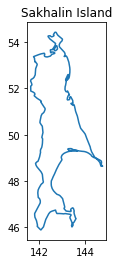

In [26]:
from pylab import *
plot(contour_sakhalin[:,0], contour_sakhalin[:,1])
gca().set_aspect('equal')
title('Sakhalin Island')
show()

Контур представлен 835 точками.

In [27]:
contour_sakhalin.shape

(835, 2)

Ограничивающий область прямоугольник легко может быть найден из спецификации shape-файла:

In [28]:
sakhalin_shp.bbox

[141.63803100585938, 45.88860321044922, 144.75164794921875, 54.424713134765625]

В соответствии с формой поисковых запросов, создадим запрос к базе данных

In [29]:
query_sakhalin_bbox = tuple(zip(['lonl', 'latl', 'lonu', 'latu'], map(str, sakhalin_shp.bbox)))
print(query_sakhalin_bbox)

(('lonl', '141.63803100585938'), ('latl', '45.88860321044922'), ('lonu', '144.75164794921875'), ('latu', '54.424713134765625'))


In [30]:
within_sakhalin_request_url = HERBARIUM_SEARCH_URL + '?' + '&'.join(map(lambda x: x[0] + '=' + quote(x[1].strip()), query_sakhalin_bbox))

In [31]:
within_sakhalin_request_url

'http://botsad.ru/hitem/json/?lonl=141.63803100585938&latl=45.88860321044922&lonu=144.75164794921875&latu=54.424713134765625'

Получение данных:

In [32]:
server_response = urlopen(within_sakhalin_request_url)
sakhalin_data_in_bbox = pd.DataFrame(json.loads(server_response.read().decode('utf-8'))['data'])

Импортирование модуля shapely для тонкой проверки принадлежности точек контуру о. Сахалин

In [33]:
from shapely.geometry import Polygon, Point
closed_sakhalin_contour = np.vstack([contour_sakhalin, contour_sakhalin[-1]])
sakhalin_poly = Polygon(closed_sakhalin_contour)

In [34]:
sakhalin_filtered = sakhalin_data_in_bbox[[sakhalin_poly.contains(Point(x,y)) for x,y in zip(sakhalin_data_in_bbox.longitude, sakhalin_data_in_bbox.latitude)]]

In [35]:
sakhalin_filtered

,acronym,additionals,altitude,branch,collection_finished,collection_started,collectors,country,country_id,created,...,note,region,short_note,significance,species_authorship,species_epithet,species_fullname,species_id,species_status,updated
0,VBGI,[],792,,,2016-10-01,Пименова Е.А.,Russia,162,2017-01-16,...,,Сахалинская обл.,,,F.Schmidt,ssiori,Prunus ssiori F.Schmidt,506834,From plantlist,2017-06-13
1,VBGI,[],1042,,,2016-10-01,Пименова Е.А.,Russia,162,2017-01-16,...,,Сахалинская обл.,,,Nakai,axillare,Vaccinium axillare Nakai,225901,From plantlist,2017-06-13
2,VBGI,[],792,,,2016-10-01,Пименова Е.А.,Russia,162,2017-01-16,...,,Сахалинская обл.,,,F.Schmidt,rugosa,Ilex rugosa F.Schmidt,44334,From plantlist,2017-06-13
3,VBGI,[],1042,,,2016-10-01,Пименова Е.А.,Russia,162,2017-01-16,...,,Сахалинская обл.,,,(Koidz.) H.Ohba,nipponica,Cerasus nipponica (Koidz.) H.Ohba,499916,From plantlist,2017-06-13
4,VBGI,[],1042,,,2016-10-01,Пименова Е.А.,Russia,162,2017-01-16,...,,Сахалинская обл.,,,(Cham. & Schltdl.) M.Roem.,sambucifolia,Sorbus sambucifolia (Cham. & Schltdl.) M.Roem.,518523,From plantlist,2017-06-13
5,VBGI,[],1042,,,2016-10-01,Пименова Е.А.,Russia,162,2017-01-16,...,,Сахалинская обл.,,,A.Gray,smallii,Vaccinium smallii A.Gray,226494,From plantlist,2017-06-13
6,VBGI,[],792,,,2016-10-01,Пименова Е.А.,Russia,162,2017-01-16,...,,Сахалинская обл.,,,Jancz.,latifolium,Ribes latifolium Jancz.,251865,From plantlist,2017-06-13
7,VBGI,[],1042,,,2016-10-01,Пименова Е.А.,Russia,162,2017-01-16,...,,Сахалинская обл.,,,Hult‚n,beauverdiana,Spiraea beauverdiana Hult‚n,518694,From plantlist,2017-06-13
8,VBGI,[],192,,,2016-09-29,Пименова Е.А.,Russia,162,2017-01-16,...,,Сахалинская обл.,,,Cham.,ermanii,Betula ermanii Cham.,68288,From plantlist,2017-06-13
9,VBGI,[],192,,,2016-09-29,Пименова Е.А.,Russia,162,2017-01-16,...,,Сахалинская обл.,,,Cham.,ermanii,Betula ermanii Cham.,68288,From plantlist,2017-06-13


In [36]:
sakhalin_data_in_bbox.shape

(241, 38)

Найдем ID точек, которые принадлежат прямоугольным границам о. Сахалин, но "не принадлежат" контору острова по результатам более тонкой фильтрации.

In [37]:
set(sakhalin_data_in_bbox.id.values) - set(sakhalin_filtered.id.values)

{1403,
 1412,
 1432,
 1434,
 1438,
 1439,
 1529,
 10015,
 10016,
 10373,
 19820,
 19823,
 19912,
 20830,
 20832}

Исследуя реальные положения перечисленных точек, например, с ID=1412 (см. страницу http://botsad.ru/hitem/1412) обнаружим, что отфильтрованные точки -- это прибрежные точки, которые либо в силу погрешностей контура shape-файла, либо в силу ошибок позиционирования гербарного сбора, выходят за определенный в shape-файле контур о. Сахалин.
Тем не менее, задача решена правильно: точки не принадлежащие текущему контуру о. Сахалин отброшены.

Таким оразом, результирующий массив данных представлен переменной `sakhalin_filtered`.

Получим данные о гербарных сборах вблизи г. Петропавловск-Камчатский.

Для выделения объектов, принадлежащих 200-км области вокруг города, определим прямоугольную область, заведомо включающую данную окрестность.
Такой прямоугольной областью может быть, например, `kamchatka_bbox`:

In [38]:
kamchatka_bbox = [151.1, 47.8, 172.0, 58.3]
petropavlovsk_coords = (53.145992, 158.683548)

Для вычисления расстояний нам потребуется дополнительный пакет `geopy`. В остальном, формирование поискового url повторяет случай для о. Сахалин.

In [39]:
from geopy.distance import vincenty
query_kamchatka_bbox = tuple(zip(['lonl', 'latl', 'lonu', 'latu'], map(str, kamchatka_bbox)))
near_petropavlovsk_kamchatsky_url = HERBARIUM_SEARCH_URL + '?' + '&'.join(map(lambda x: x[0] + '=' + quote(x[1].strip()), query_kamchatka_bbox))
server_response = urlopen(near_petropavlovsk_kamchatsky_url)
petropavlovsk_data_in_bbox = pd.DataFrame(json.loads(server_response.read().decode('utf-8'))['data'])
petropavlovsk_data_in_bbox.shape

(157, 38)

In [40]:
petropavlovsk_filtered = petropavlovsk_data_in_bbox[[vincenty((lat, lon), petropavlovsk_coords).km < 200.0 for lat,lon in zip(petropavlovsk_data_in_bbox.latitude, petropavlovsk_data_in_bbox.longitude)]]

In [41]:
petropavlovsk_filtered.shape

(67, 38)

Данные о гербарных сборах в пределах 200-км зоны вокруг г. П.-Камчасткий получены. 
Теперь можно проводить сравнительный анализ.

In [42]:
print('Количество уникальных родов в 200 км окрестности г. П.-Камчатский:', len(petropavlovsk_filtered.genus.unique()))

Количество уникальных родов в 200 км окрестности г. П.-Камчатский: 17


In [43]:
print('Количество уникальных видов в 200 км окрестности г. П.-Камчатский:', len(petropavlovsk_filtered.species_id.unique()))

Количество уникальных видов в 200 км окрестности г. П.-Камчатский: 21


In [44]:
print('Количество уникальных видов на о. Сахалин:', len(sakhalin_filtered.species_id.unique()))

Количество уникальных видов на о. Сахалин: 95


In [45]:
print('Количество уникальных родов на о. Сахалин:', len(sakhalin_filtered.genus.unique()))

Количество уникальных родов на о. Сахалин: 72


Посчитаем частоты встречаемости видов в сборах:

In [46]:
from collections import Counter

Частоты встречаемости родов около г. П.-Камчатский

In [47]:
petr_freq = petropavlovsk_filtered.genus.value_counts() / len(petropavlovsk_filtered)
petr_freq

Riccardia       0.134328
Aneura          0.134328
Moerckia        0.104478
Dryopteris      0.089552
Peltolepis      0.089552
Conocephalum    0.074627
Calycularia     0.059701
Sauteria        0.044776
Pellia          0.044776
Preissia        0.044776
Marchantia      0.044776
Blasia          0.029851
Athyrium        0.029851
Polystichum     0.029851
Cystopteris     0.014925
Nardia          0.014925
Mannia          0.014925
Name: genus, dtype: float64

Частоты встречаемости родов на о. Сахалин

In [48]:
sakh_freq = sakhalin_filtered.genus.value_counts() / len(sakhalin_filtered)
sakh_freq

Porella           0.163717
Riccardia         0.092920
Conocephalum      0.079646
Asarum            0.053097
Dryopteris        0.035398
Marchantia        0.030973
Sauteria          0.026549
Woodsia           0.026549
Reboulia          0.022124
Peltolepis        0.022124
Leptorumohra      0.022124
Asterella         0.022124
Prunus            0.017699
Cacalia           0.017699
Cardamine         0.013274
Gentiana          0.013274
Skimmia           0.013274
Cypripedium       0.013274
Phellodendron     0.013274
Euonymus          0.013274
Metzgeria         0.008850
Actinidia         0.008850
Apometzgeria      0.008850
Betula            0.008850
Blasia            0.008850
Cortusa           0.008850
Pellia            0.008850
Fossombronia      0.008850
Aneura            0.008850
Quercus           0.008850
                    ...   
Botrychium        0.004425
Galium            0.004425
Cryptotaenia      0.004425
Potentilla        0.004425
Trautvetteria     0.004425
Pleurospermum     0.004425
C

Информационные меры неопределенности (биоразнообразие по К. Шеннону):

In [49]:
shannon_sakh = - sum(np.log2(sakh_freq.values) * sakh_freq.values)
shannon_sakh

5.1887384234106477

In [50]:
shannon_petr = - sum(np.log2(petr_freq.values) * petr_freq.values)
shannon_petr

3.792076131172557

Вычислим относительные значения мер (от их максимального теоретического значения в каждом случае):

In [51]:
shannon_sakh_relative = shannon_sakh / np.log2(len(sakh_freq))
shannon_sakh_relative

0.84097268965144678

In [52]:
shannon_petr_relative = shannon_petr / np.log2(len(petr_freq))
shannon_petr_relative

0.92773348124495136

Как ни странно, относительное разнообразие сборов несколько выше в окр. г. П.-Камчатский, хотя эти различия могут отражать лишь специфику данных, занесенных в базу на текущий момент времени.

In [53]:
import datetime
print("Дата выполнения кода документа: ", datetime.datetime.now())

Дата выполнения кода документа:  2017-07-31 18:51:41.156435
